In [1]:
# import necessary libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# preprocessing and modeling
import itertools
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

# global parameters 
RANDOMSTATE = 101



In [2]:
# load data 
sensor_data = pd.read_csv('s3dataset.csv')

In [3]:
# take a quick look at dataframe 
sensor_data.head()

,Unnamed: 0,timestamp,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,...,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,machine_status
0,0,2018-04-01 00:00:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
1,1,2018-04-01 00:01:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
2,2,2018-04-01 00:02:00,2.444734,47.35243,53.2118,46.397570,638.8889,73.54598,13.32465,16.03733,...,41.66666,39.351852,65.39352,51.21528,38.194443,155.9606,67.12963,241.3194,203.7037,NORMAL
3,3,2018-04-01 00:03:00,2.460474,47.09201,53.1684,46.397568,628.1250,76.98898,13.31742,16.24711,...,40.88541,39.062500,64.81481,51.21528,38.194440,155.9606,66.84028,240.4514,203.1250,NORMAL
4,4,2018-04-01 00:04:00,2.445718,47.13541,53.2118,46.397568,636.4583,76.58897,13.35359,16.21094,...,41.40625,38.773150,65.10416,51.79398,38.773150,158.2755,66.55093,242.1875,201.3889,NORMAL


In [4]:
# see the labels we have 
sensor_data['machine_status'].unique()

array(['NORMAL', 'BROKEN', 'RECOVERING'], dtype=object)

Great we see a general overview of the sensor data as well as the labels we will be working with. Next, we can take a look at the statistics presented in the raw data. This is one way to get a sense of the distribution of data as well as look for missing values. 

In [5]:
# get more info from the dataset 
sensor_data.describe()

,Unnamed: 0,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,...,sensor_42,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51
count,220320.000000,210112.000000,219951.000000,220301.000000,220301.000000,220301.000000,220301.000000,215522.000000,214869.000000,215213.000000,...,220293.000000,220293.000000,220293.000000,220293.000000,220293.000000,220293.000000,220293.000000,220293.000000,143303.000000,204937.000000
mean,110159.500000,2.372221,47.591611,50.867392,43.752481,590.673936,73.396414,13.501537,15.843152,15.200721,...,35.453455,43.879591,42.656877,43.094984,48.018585,44.340903,150.889044,57.119968,183.049260,202.699667
std,63601.049991,0.412227,3.296666,3.666820,2.418887,144.023912,17.298247,2.163736,2.201155,2.037390,...,10.259521,11.044404,11.576355,12.837520,15.641284,10.442437,82.244957,19.143598,65.258650,109.588607
min,0.000000,0.000000,0.000000,33.159720,31.640620,2.798032,0.000000,0.014468,0.000000,0.028935,...,22.135416,24.479166,25.752316,26.331018,26.331018,27.199070,26.331018,26.620370,27.488426,27.777779
25%,55079.750000,2.438831,46.310760,50.390620,42.838539,626.620400,69.976260,13.346350,15.907120,15.183740,...,32.812500,39.583330,36.747684,36.747684,40.509258,39.062500,83.912030,47.743060,167.534700,179.108800
50%,110159.500000,2.456539,48.133678,51.649300,44.227428,632.638916,75.576790,13.642940,16.167530,15.494790,...,35.156250,42.968750,40.509260,40.219910,44.849540,42.534720,138.020800,52.662040,193.865700,197.338000
75%,165239.250000,2.499826,49.479160,52.777770,45.312500,637.615723,80.912150,14.539930,16.427950,15.697340,...,36.979164,46.614580,45.138890,44.849540,51.215280,46.585650,208.333300,60.763890,219.907400,216.724500
max,220319.000000,2.549016,56.727430,56.032990,48.220490,800.000000,99.999880,22.251160,23.596640,24.348960,...,374.218800,408.593700,1000.000000,320.312500,370.370400,303.530100,561.632000,464.409700,1000.000000,1000.000000


In [6]:
# get further info from dataset
sensor_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220320 entries, 0 to 220319
Data columns (total 55 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Unnamed: 0      220320 non-null  int64  
 1   timestamp       220320 non-null  object 
 2   sensor_00       210112 non-null  float64
 3   sensor_01       219951 non-null  float64
 4   sensor_02       220301 non-null  float64
 5   sensor_03       220301 non-null  float64
 6   sensor_04       220301 non-null  float64
 7   sensor_05       220301 non-null  float64
 8   sensor_06       215522 non-null  float64
 9   sensor_07       214869 non-null  float64
 10  sensor_08       215213 non-null  float64
 11  sensor_09       215725 non-null  float64
 12  sensor_10       220301 non-null  float64
 13  sensor_11       220301 non-null  float64
 14  sensor_12       220301 non-null  float64
 15  sensor_13       220301 non-null  float64
 16  sensor_14       220299 non-null  float64
 17  sensor_15 

From this information, we see we have a handful of missing values. We will delete the following columns. 

In [7]:
# we see that one column (sensor_15) has no values therefore we will delete that column 
sensor_data = sensor_data.drop('sensor_15', axis = 1)

In [8]:
# sensor 50 also is missing 34.95% of its data so we will delete that column as well. 
sensor_data = sensor_data.drop('sensor_50', axis =1) 

In [9]:
# We will delete sensor_00 and sensor_51 which are both missing close to 6-7% of their data. 
# as well as the Unnamed:0 column which is essentially the index column duplicate
sensor_data = sensor_data.drop('Unnamed: 0', axis =1)
sensor_data = sensor_data.drop('sensor_00', axis =1) 
sensor_data = sensor_data.drop('sensor_51', axis =1) 


Next, we see a missing data heatmap after we removed the prior columns. We see we still have missing values.

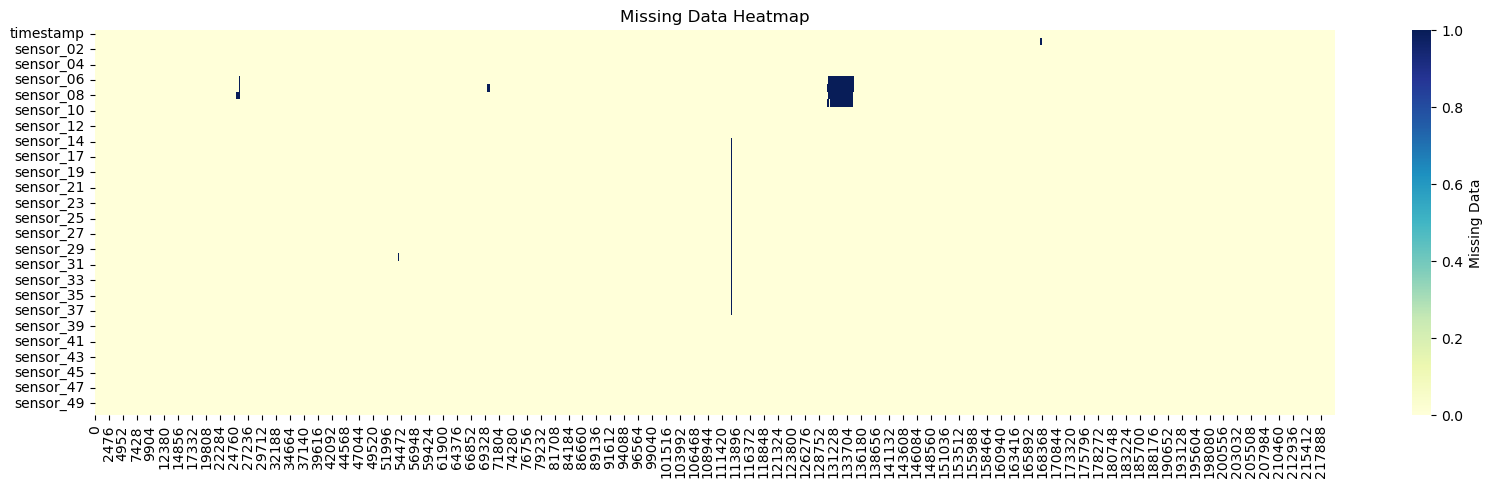

In [13]:
# this cell is hidden for easier notebook readability.
# plot a heatmap of the missing values
plt.figure(figsize=(20,5))
sns.heatmap(sensor_data.isna().transpose(),
            cmap="YlGnBu",
            cbar_kws={'label': 'Missing Data'})
plt.title('Missing Data Heatmap')
plt.show();

In [14]:
#split data 60/40 with last 40% as the test set
last_40percent = round(len(sensor_data) - len(sensor_data)*.4)
train = sensor_data.iloc[ :last_40percent, :]
test = sensor_data.iloc[last_40percent: ,:]

In [15]:
test[test['machine_status']=='BROKEN']

,timestamp,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,...,sensor_41,sensor_42,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,machine_status
141131,2018-07-08 00:11:00,45.138890,52.90799,45.35590,500.000000,1.40131,0.028935,0.036169,0.036169,0.007234,...,35.41666,32.81250,36.19791,37.32639,35.30093,38.19444,43.40278,99.53703,44.84954,BROKEN
166440,2018-07-25 14:00:00,45.833332,52.99479,43.88021,420.503448,72.52040,14.185470,16.247110,15.697340,15.053530,...,35.41666,36.45833,51.30208,52.10200,52.66204,67.12963,43.98148,230.32410,69.73380,BROKEN


In [16]:
# get useful columns and rows
sensor_cols = train.iloc[:,1:49]
broken_rows = train[train['machine_status']=='BROKEN']
recovery_rows = train[train['machine_status']=='RECOVERING']
normal_rows = train[train['machine_status']=='NORMAL']
machine_status_col = train['machine_status']

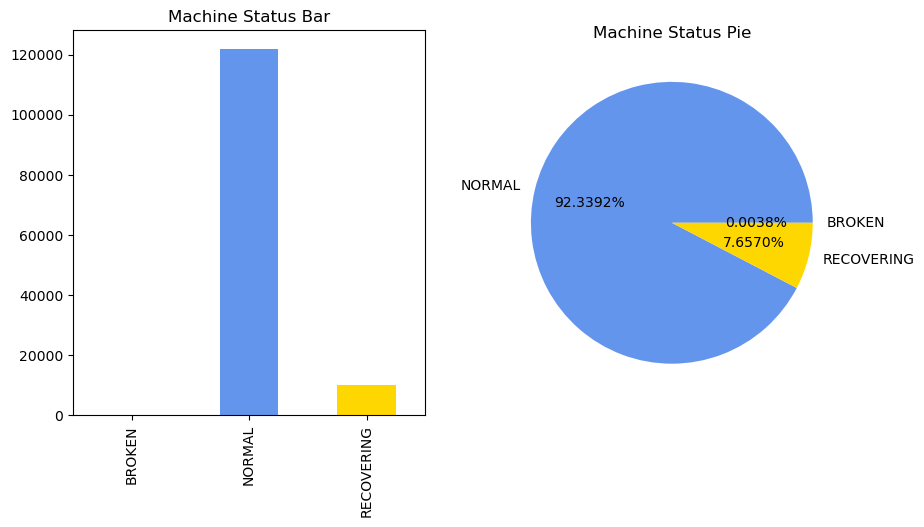

In [17]:
# this cell is hidden for easier notebook readability.

# pie chart of machine status
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,5))
train.groupby('machine_status').size().plot(kind='bar', ax=ax1, color=['black', 'cornflowerblue', 'gold'])
train.groupby('machine_status').size().plot(kind='pie', ax=ax2, autopct='%.4f%%', colors=['black', 'cornflowerblue', 'gold'])
ax1.set_title('Machine Status Bar')
ax1.set_xlabel('')
ax2.set_title('Machine Status Pie')
ax2.set_ylabel('')
plt.show();

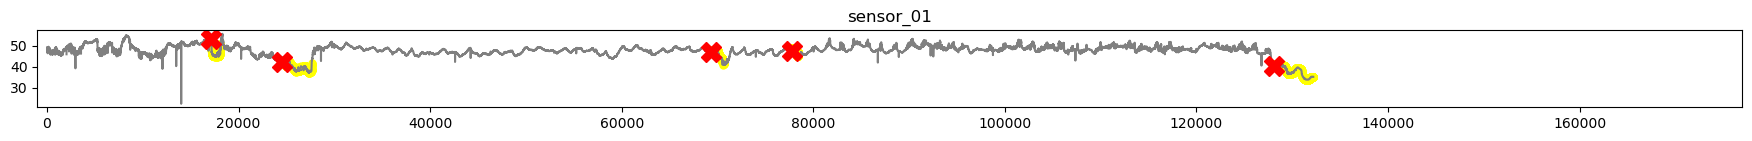

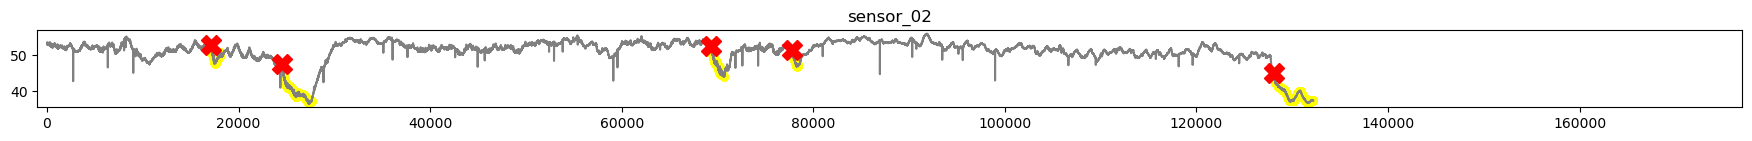

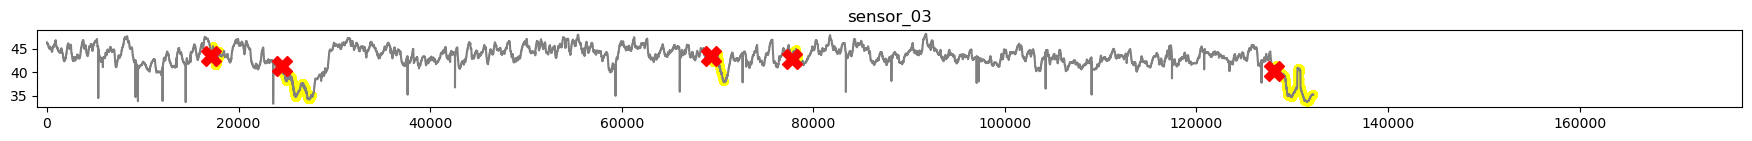

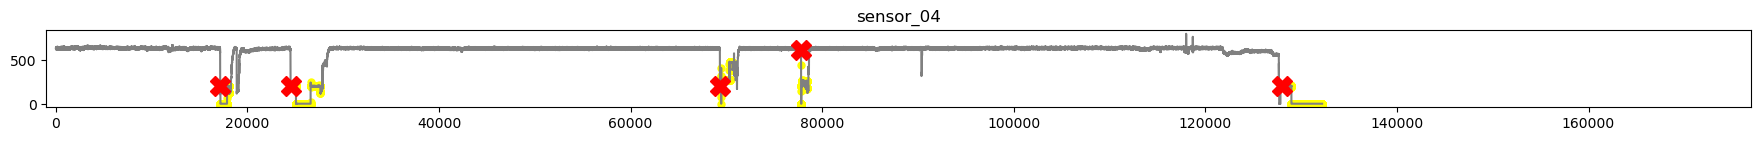

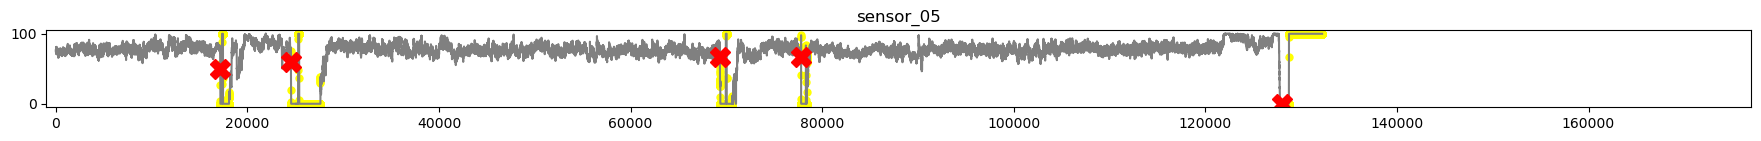

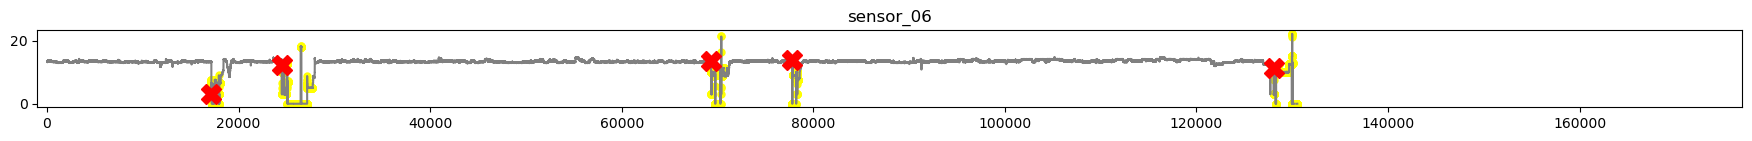

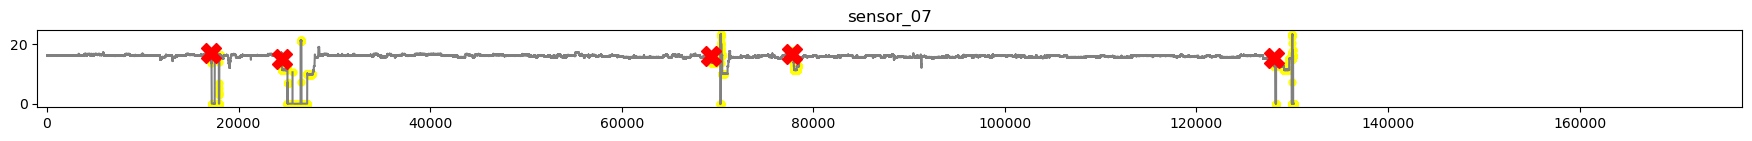

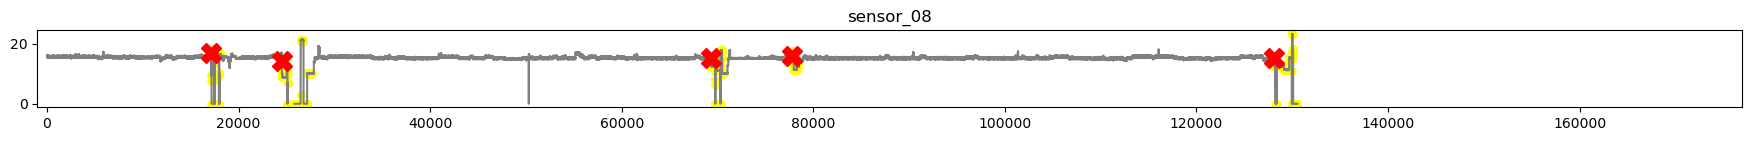

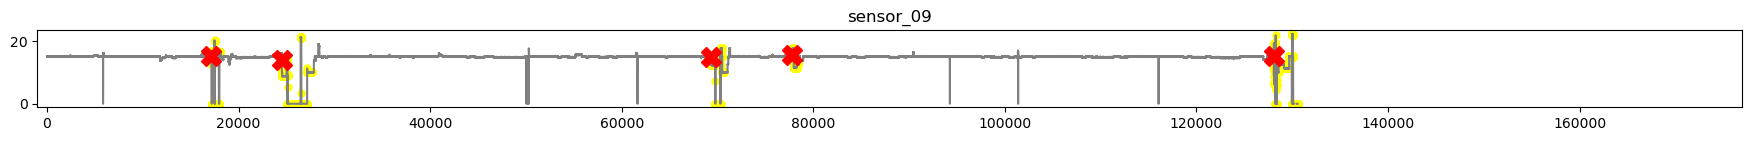

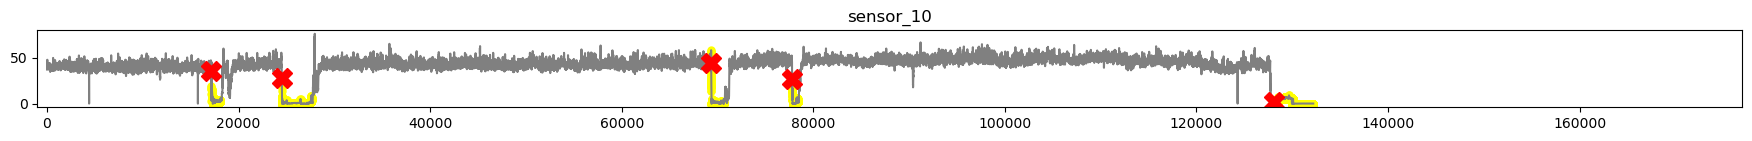

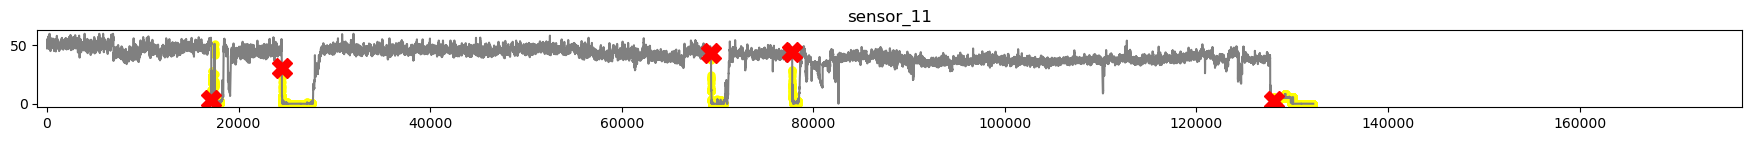

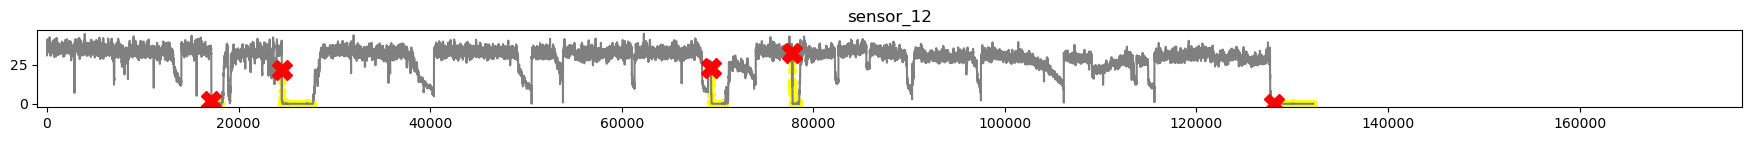

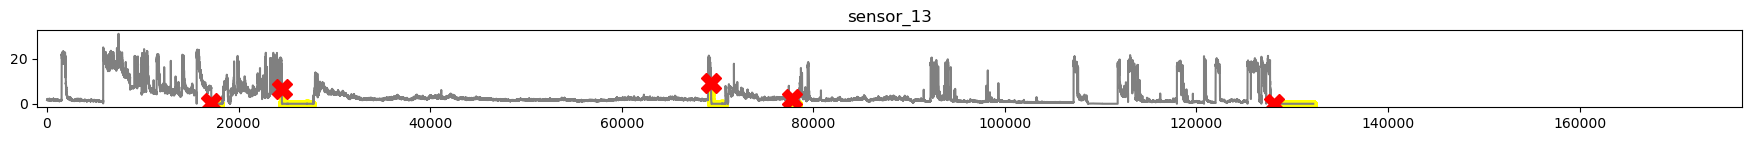

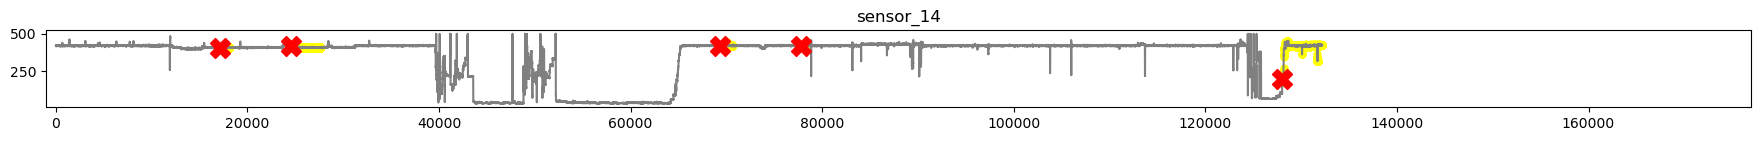

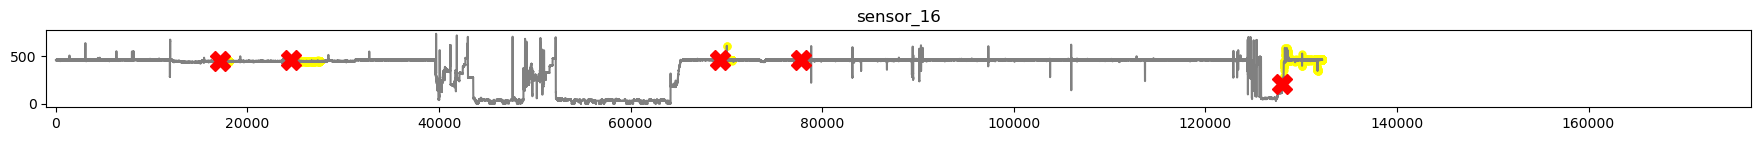

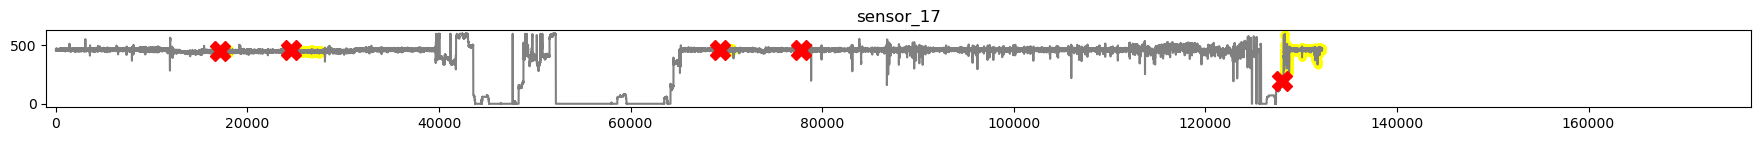

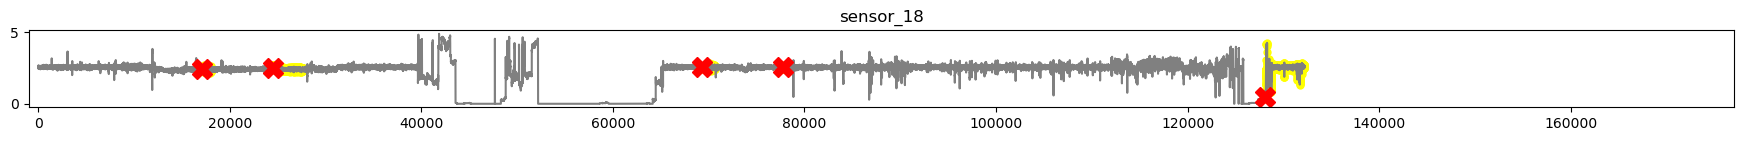

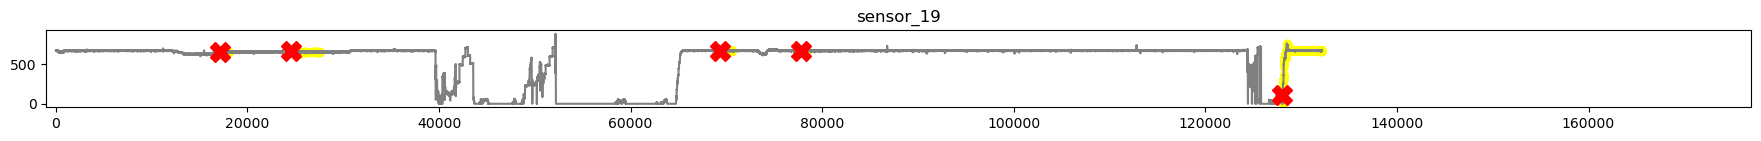

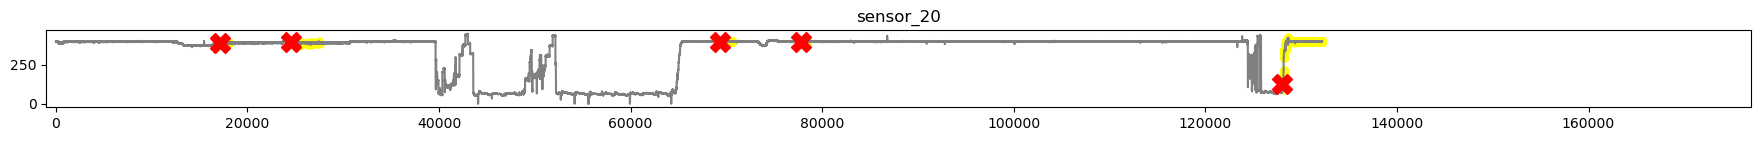

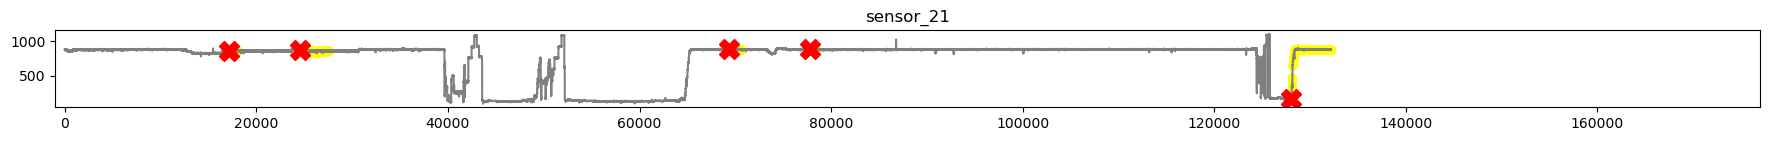

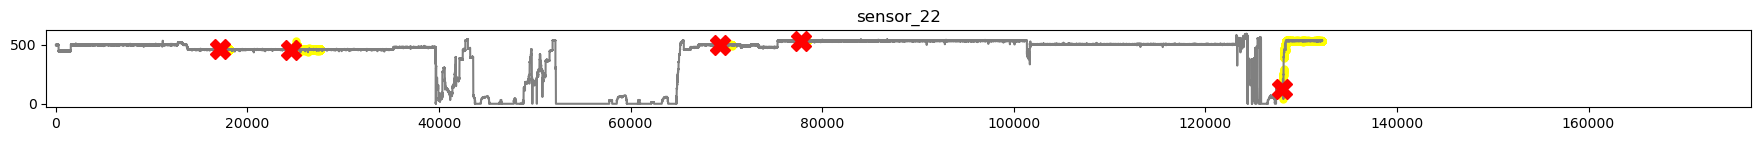

KeyboardInterrupt: 

In [18]:
for sensor in sensor_cols:
    plot = plt.figure(figsize=(22,1))
    plot = plt.plot(recovery_rows[sensor], linestyle='none', marker='o', color='yellow', markersize=5)
    plot = plt.plot(train[sensor], color='grey')
    plot = plt.plot(broken_rows[sensor], linestyle='none', marker='X', color='red', markersize=14)
    plot = plt.title(sensor)
    plt.xlim((-1000,177000))
    plt.show();

In [19]:
# split data into X and y (data and labels)         
X_cols = train.iloc[ : , 1:-1].columns
X_train = train.iloc[:,1:-1].copy()
y_train = train['machine_status']

In [20]:
#fill NA's with forward fill propogation
X_train = X_train.fillna(method='ffill')

In [21]:
# normalize data 
normalize = Normalizer()
X_train = normalize.fit_transform(X_train)
X_train = pd.DataFrame(X_train)
X_train.columns = X_cols

In [22]:
# function used in class to find the best labels in an unsupervised model

def label_permute_compare(y,ypred, n=3):
    """A helper function to find the best label - number combo """
    results = pd.DataFrame(y)
    perms = list(itertools.permutations([0, 1, 2]))      #create permutation list
    best_labels = []
    best_acc = 0 
    current = {}
    labels = ['NORMAL', 'BROKEN', 'RECOVERING']
    for perm in perms:
        for i in range(n):
            current[labels[i]] = perm[i]
            if len(current) == 3:
                conditions = [
                    (y['machine_status'] == current['NORMAL']),
                    (y['machine_status'] == current['BROKEN']),
                    (y['machine_status'] == current['RECOVERING'])]
                results['test'] = results['machine_status'].map(current)
                current_accuracy = accuracy_score(results['test'], ypred)
                if current_accuracy > best_acc: 
                    best_acc = current_accuracy
                    best_labels = perm
                    results['best'] = results['test']
    return best_labels, best_acc


In [23]:
pca = PCA(n_components = .99, svd_solver = 'full', random_state = RANDOMSTATE )
pca.fit(X_train)
print(f'Number of components after reduction: {pca.n_components_}')

Number of components after reduction: 16


In [24]:
n_comps = pca.n_components_
most_important_comps = [np.abs(pca.components_[i]).argmax() for i in range(n_comps)]
intital_features = list(X_train.columns)
most_important_sensors = [intital_features[most_important_comps[i]] for i in range(n_comps)]
dic = {'PC{}'.format(i+1): most_important_sensors[i] for i in range(n_comps)}
df = pd.DataFrame(sorted(dic.items()))
print("Most Important Features") 
df

Most Important Features


,0,1
0,PC1,sensor_04
1,PC10,sensor_32
2,PC11,sensor_32
3,PC12,sensor_48
4,PC13,sensor_33
5,PC14,sensor_48
6,PC15,sensor_23
7,PC16,sensor_16
8,PC2,sensor_36
9,PC3,sensor_27


In [25]:
reduced_X_train = pca.transform(X_train)

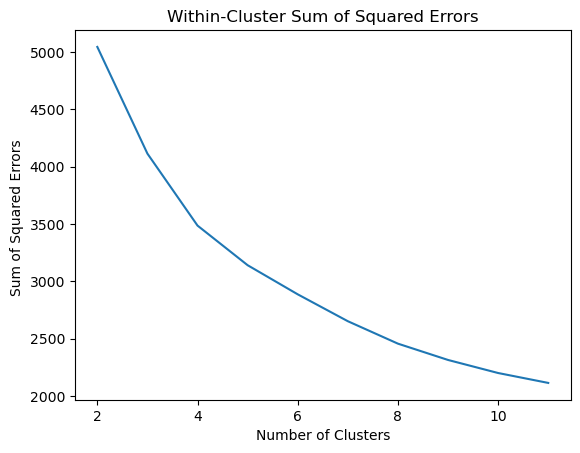

In [26]:
# visualize errors based on number of clusters
error = []
K = range(2,12)
for k in K:
    kmeans = KMeans(n_clusters = k, 
                    max_iter = 500, 
                    init = 'k-means++', 
                    n_init = 20, 
                    random_state = RANDOMSTATE)
    kmeans_fit = kmeans.fit(reduced_X_train)
    error.append(kmeans.inertia_)

plt.xlabel('Number of Clusters')
plt.ylabel('Sum of Squared Errors ')
plt.title('Within-Cluster Sum of Squared Errors')
plt.plot(K,error);

In [27]:
# find best KMeans model parameters based on the training data
parameters = {'algorithm' : ['auto', 'elkan'], 
              'n_clusters':[3,4,5]}

model_results = {}
ytrue = pd.DataFrame(y_train, columns=['machine_status'])
for alg in parameters['algorithm']: 
    for n in parameters['n_clusters']:
        kmeans = KMeans(n_clusters = n,
                        algorithm = alg,
                        max_iter = 500, 
                        init = 'k-means++', 
                        random_state = RANDOMSTATE)
        kmeans.fit(reduced_X_train)
        ypred = kmeans.predict(reduced_X_train)
        best_labels, best_acc = label_permute_compare(ytrue,ypred, n=3)
        model_results[(alg, n)] = {'accuracy':round(best_acc, 4), 'labels': best_labels}

In [28]:
# show model results based on parameters set in model 
model_results

{('auto', 3): {'accuracy': 0.425, 'labels': (2, 0, 1)},
 ('auto', 4): {'accuracy': 0.3794, 'labels': (2, 0, 1)},
 ('auto', 5): {'accuracy': 0.3748, 'labels': (0, 1, 2)},
 ('elkan', 3): {'accuracy': 0.425, 'labels': (2, 0, 1)},
 ('elkan', 4): {'accuracy': 0.3794, 'labels': (2, 0, 1)},
 ('elkan', 5): {'accuracy': 0.3748, 'labels': (0, 1, 2)}}

In [29]:
# train kmeans model with best parameters
kmeans = KMeans(n_clusters = 3, 
                algorithm = 'auto',
                init = 'k-means++',
                max_iter = 500,
                random_state = RANDOMSTATE)
kmeans.fit(reduced_X_train)

KMeans(max_iter=500, n_clusters=3, random_state=101)

Now we have our KMeans model ready to go. We will test it on our test set. We must first preprocess our test data just like we did the training data so that the model has the best chance of success. The reason we did not apply fillna(), Normalizer() and PCA on the whole dataset (training and test together) is because that can lead to data leakage and impact the final results, and even cause false results. For this, we split first then apply separately. 

In [30]:
# preprocess testing data as we did with the training data
X_cols = test.iloc[ : , 1:-1].columns
X_test = test.iloc[:,1:-1].copy()
y_test = test['machine_status']
X_test = X_test.fillna(method='ffill')
normalize = Normalizer(copy=True)
X_test = normalize.fit_transform(X_test[most_important_sensors])

In [31]:
# predict the testing set using KMeans
ypred = kmeans.predict(X_test)
ytrue = pd.DataFrame(y_test, columns=['machine_status'])
best_labels, best_acc = label_permute_compare(ytrue,ypred, n=3)
print('Test Accuracy:', round(best_acc,4), '\n', 'Best labels:', best_labels)

Test Accuracy: 0.9444 
 Best labels: (2, 0, 1)


In [32]:
# Look at precision and recall 
precision, recall, fscore, support = precision_recall_fscore_support(ytrue['best'], ypred, 
                                                                     zero_division=1, 
                                                                     average = 'micro')
print('Test Precision:', round(precision,4))
print('Test Recall:   ', round(recall, 4))

Test Precision: 0.9444
Test Recall:    0.9444


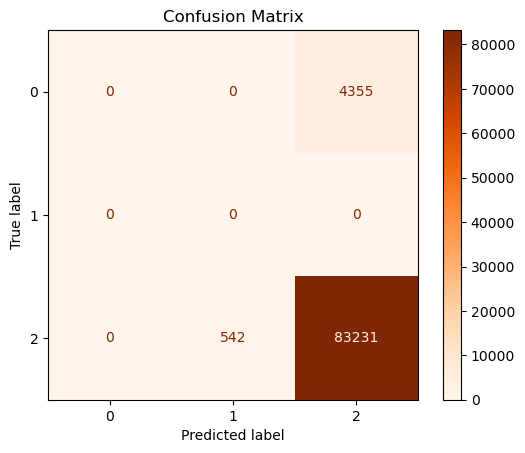

In [33]:
# create visual confusion matrix
ConfusionMatrixDisplay.from_predictions(ytrue['best'], ypred, cmap='Oranges')
plt.title('Confusion Matrix')
plt.show();

In [34]:
print(f'Unique values in test predictions: {list(np.unique(ypred))}')

Unique values in test predictions: [1, 2]


In [35]:
# re-preprocess data to ensure fresh start of training and testing data
X_train = train.iloc[:,1:-1].copy()
y_train = train['machine_status']
X_train = X_train.fillna(method='ffill')
normalize = Normalizer()
X_train = normalize.fit_transform(X_train)
X_train = pd.DataFrame(X_train)
X_train.columns = X_cols
pca = PCA(n_components = .99, svd_solver = 'full', random_state = RANDOMSTATE )
pca.fit(X_train)
reduced_X_train = pca.transform(X_train)

most_important_sensors = [intital_features[most_important_comps[i]] for i in range(n_comps)]

X_test = test.iloc[:,1:-1].copy()
y_test = test['machine_status']
X_test = X_test.fillna(method='ffill')
normalize = Normalizer(copy=True)
X_test = normalize.fit_transform(X_test[most_important_sensors])

We have preprocessed our data again to ensure a clean slate in the new model. Now we'll use GridSearchCV with KNN to find the best parameters to use with this model.

In [36]:
data =  pd.read_csv('s3dataset.csv')

In [37]:
data = data.drop('sensor_15', 1)
data = data.drop('Unnamed: 0', 1)
data.shape

C:\Users\SAKTHI BABU\AppData\Local\Temp\ipykernel_18940\3094458207.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  data = data.drop('sensor_15', 1)
C:\Users\SAKTHI BABU\AppData\Local\Temp\ipykernel_18940\3094458207.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  data = data.drop('Unnamed: 0', 1)


(220320, 53)

In [38]:
data['date'] = data['timestamp'].apply(lambda x: x.split(' ')[0])
data['time'] = data['timestamp'].apply(lambda x: x.split(' ')[1])
data = data.drop(['timestamp'], 1)

C:\Users\SAKTHI BABU\AppData\Local\Temp\ipykernel_18940\1572225245.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  data = data.drop(['timestamp'], 1)


In [39]:
data_imputed = data.fillna(data.median())

C:\Users\SAKTHI BABU\AppData\Local\Temp\ipykernel_18940\3770847838.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  data_imputed = data.fillna(data.median())


array([[<AxesSubplot:title={'center':'sensor_00'}>,
        <AxesSubplot:title={'center':'sensor_01'}>,
        <AxesSubplot:title={'center':'sensor_02'}>,
        <AxesSubplot:title={'center':'sensor_03'}>,
        <AxesSubplot:title={'center':'sensor_04'}>,
        <AxesSubplot:title={'center':'sensor_05'}>,
        <AxesSubplot:title={'center':'sensor_06'}>],
       [<AxesSubplot:title={'center':'sensor_07'}>,
        <AxesSubplot:title={'center':'sensor_08'}>,
        <AxesSubplot:title={'center':'sensor_09'}>,
        <AxesSubplot:title={'center':'sensor_10'}>,
        <AxesSubplot:title={'center':'sensor_11'}>,
        <AxesSubplot:title={'center':'sensor_12'}>,
        <AxesSubplot:title={'center':'sensor_13'}>],
       [<AxesSubplot:title={'center':'sensor_14'}>,
        <AxesSubplot:title={'center':'sensor_16'}>,
        <AxesSubplot:title={'center':'sensor_17'}>,
        <AxesSubplot:title={'center':'sensor_18'}>,
        <AxesSubplot:title={'center':'sensor_19'}>,
        <A

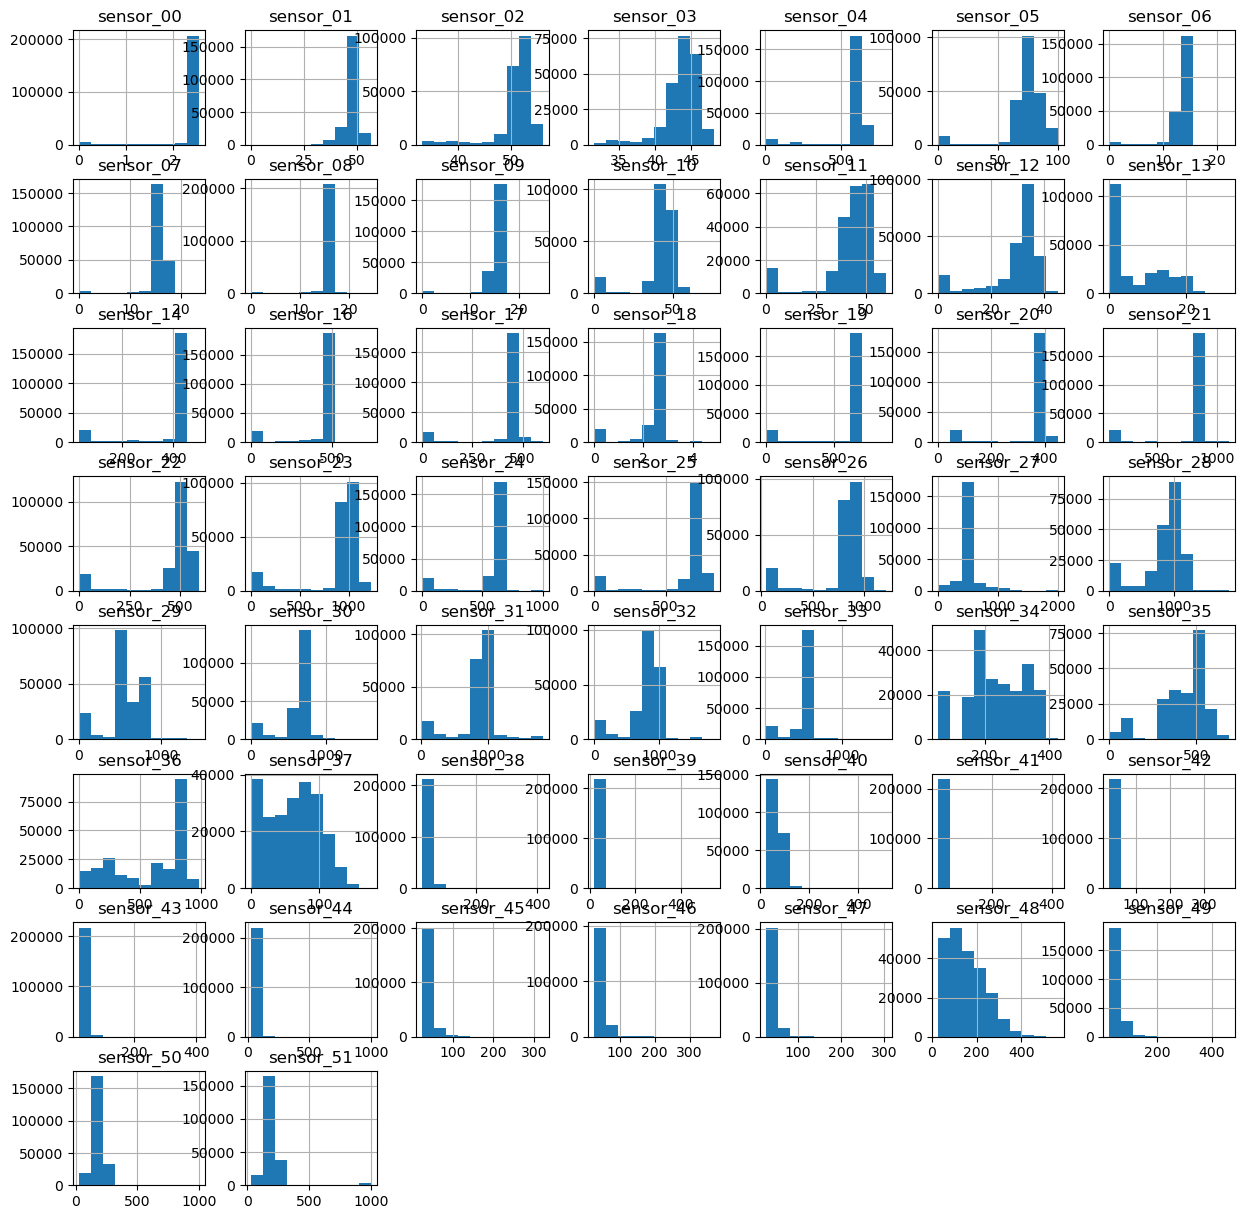

In [40]:
data_imputed.hist(figsize=(15,15))

In [41]:
from scipy.stats import zscore
z_scores = zscore(data_imputed.iloc[:,:51])
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)
data_outlir = data_imputed[filtered_entries]

In [42]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
data_std = scaler.fit_transform(data_outlir.iloc[:,:51])
data_std = pd.DataFrame(data_std)

In [43]:
data_va = data_std.var(axis= 0)
data_vas = data_va.sort_values(ascending=False)
y = data_vas.values 
x = range(len(y))

In [44]:
corrmatrix = data_std.corr()

In [45]:
# doing multicollinearity test
def correlation(dataset, threshold):
    col_corr = set() # Set of all the names of deleted columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if (abs(corr_matrix.iloc[i, j]) >= threshold) and (corr_matrix.columns[j] not in col_corr):
                colname = corr_matrix.columns[i] # getting the name of column
                col_corr.add(colname)
                if colname in dataset.columns:
                    del dataset[colname] # deleting the column from the dataset

    return dataset

In [46]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
Y = le.fit_transform(data_outlir['machine_status'])

In [47]:
X = correlation(data_std, 0.7)
X

,0,1,2,3,4,5,6,7,8,10,...,38,39,43,44,45,46,47,48,49,50
0,0.939112,0.480094,0.825268,0.837036,0.733213,0.658273,0.666983,0.576098,0.600776,0.520389,...,0.131004,0.4025,0.216867,0.689266,0.307340,0.162338,0.345454,0.437063,0.671642,0.400288
1,0.939112,0.480094,0.825268,0.837036,0.733213,0.658273,0.666983,0.576098,0.600776,0.520389,...,0.131004,0.4025,0.216867,0.689266,0.307340,0.162338,0.345454,0.437063,0.671642,0.400288
2,0.924069,0.494145,0.825268,0.844444,0.740484,0.615974,0.655629,0.562820,0.606202,0.530791,...,0.126638,0.3925,0.210843,0.683616,0.311927,0.162338,0.339921,0.430070,0.666045,0.406047
3,0.935530,0.480094,0.822580,0.844444,0.723145,0.665955,0.654684,0.592442,0.614729,0.542358,...,0.131004,0.4175,0.204819,0.672316,0.311927,0.162338,0.339921,0.426573,0.663246,0.404608
4,0.924786,0.482435,0.825268,0.844444,0.736569,0.660148,0.659414,0.587335,0.614729,0.557134,...,0.131004,0.4625,0.198795,0.677966,0.321101,0.175325,0.346245,0.423077,0.668843,0.400288
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165196,0.894699,0.512881,0.658602,0.566666,0.727993,0.514248,0.886472,0.656794,0.610077,0.551044,...,0.069869,0.3725,0.819277,0.169492,0.238532,0.207792,0.723320,0.842657,0.513060,0.396688
165197,0.891117,0.512881,0.661290,0.566666,0.726874,0.524737,0.900663,0.637385,0.600776,0.560804,...,0.065502,0.3500,0.831325,0.175141,0.243119,0.214286,0.716996,0.919580,0.513060,0.403168
165198,0.894699,0.512881,0.658602,0.566666,0.721281,0.544452,0.890255,0.643515,0.610077,0.562393,...,0.069869,0.3225,0.837349,0.197740,0.256881,0.214286,0.701976,0.972028,0.513060,0.406047
165199,0.894699,0.512881,0.661290,0.566666,0.736261,0.521871,0.886472,0.656794,0.618605,0.569222,...,0.069869,0.3125,0.843374,0.237288,0.252294,0.214286,0.674308,0.982517,0.513060,0.406047


In [48]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import linear_model
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn import linear_model
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.cluster import KMeans

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.17, random_state=42)

In [50]:
clf5 = SVC(gamma='auto').fit(X_train, y_train)
y_pred5 = clf5.predict(X_test)

In [51]:
from sklearn.metrics import roc_auc_score
acc_svm_model=roc_auc_score(y_test, y_pred5)*100
acc_svm_model

95.83333333333333

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.16, random_state=42)

In [53]:
clf5 = SVC(gamma='auto').fit(X_train, y_train)
y_pred5 = clf5.predict(X_test)

In [54]:
from sklearn.metrics import roc_auc_score
acc_svm_model=roc_auc_score(y_test, y_pred5)*100
acc_svm_model

95.45454545454545

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)
clf4 = RandomForestClassifier(max_depth=5, random_state=0).fit(X_train, y_train)
y_pred4 = clf4.predict(X_test)

In [56]:
acc_rmf_model=roc_auc_score(y_test, y_pred4)*100
acc_rmf_model

97.87234042553192

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.54, random_state=42)
clf4 = RandomForestClassifier(max_depth=5, random_state=0).fit(X_train, y_train)
y_pred4 = clf4.predict(X_test)

In [58]:
acc_rmf_model=roc_auc_score(y_test, y_pred4)*100
acc_rmf_model

97.72727272727273

In [59]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X, y = make_classification(
    n_samples=1_000,
    n_features=2,
    n_redundant=0,
    n_informative=2,
    random_state=1,
    n_clusters_per_class=1,
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)

In [60]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.svm import LinearSVC

classifiers = {
    "Linear SVM": make_pipeline(StandardScaler(), LinearSVC(C=0.028)),
    "Random Forest": RandomForestClassifier(
        max_depth=5, n_estimators=7, max_features=1
    ),
     "KNN": RandomForestClassifier(
        max_depth=2, n_estimators=2, max_features=1
    ),
    
}

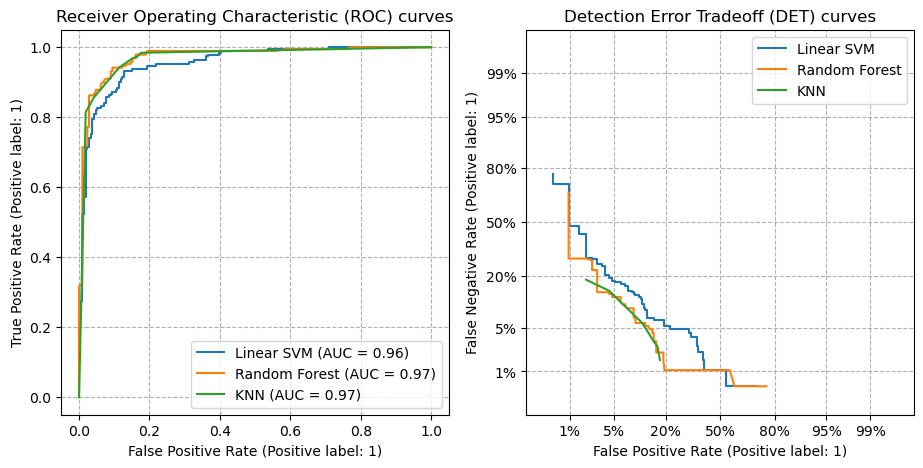

In [61]:
import matplotlib.pyplot as plt
from sklearn.metrics import DetCurveDisplay, RocCurveDisplay

fig, [ax_roc, ax_det] = plt.subplots(1, 2, figsize=(11, 5))

for name, clf in classifiers.items():
    clf.fit(X_train, y_train)

    RocCurveDisplay.from_estimator(clf, X_test, y_test, ax=ax_roc, name=name)
    DetCurveDisplay.from_estimator(clf, X_test, y_test, ax=ax_det, name=name)

ax_roc.set_title("Receiver Operating Characteristic (ROC) curves")
ax_det.set_title("Detection Error Tradeoff (DET) curves")

ax_roc.grid(linestyle="--")
ax_det.grid(linestyle="--")

plt.legend()
plt.show()

In [67]:
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
X, y = make_classification(n_samples=1000, n_classes=2, random_state=1)
# split into train/test sets
trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.5, random_state=2)

ns_probs = [0 for _ in range(len(testy))]
model = LogisticRegression(solver='lbfgs')
model.fit(trainX, trainy)
lr_probs = model.predict_proba(testX)
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(testy, ns_probs)

lr_auc = roc_auc_score(testy, lr_probs)
print('KNN f1-score : 0.92' % (ns_auc))
# summarize scores
from sklearn.metrics import roc_curve
from scipy.optimize import brentq
print('KNN: AUC=%.02f' % (lr_auc))
from scipy.interpolate import interp1d
import numpy as np
y_true = [0, 1, 1, 0]  
y_scores = [0.1, 0.3, 0.46, 0.8]  
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
eer = brentq(lambda x : 1. - x - interp1d(fpr, tpr)(x), 0., 1.)
print('KNN EER:',eer)
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(testy, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(testy, lr_probs)


KNN f1-score : 0.92
KNN: AUC=0.90
KNN EER: 0.5


In [69]:
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
X, y = make_classification(n_samples=1000, n_classes=2, random_state=1)
# split into train/test sets
trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.2, random_state=2)

ns_probs = [0 for _ in range(len(testy))]
model = LogisticRegression(solver='lbfgs')
model.fit(trainX, trainy)
lr_probs = model.predict_proba(testX)
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(testy, ns_probs)

lr_auc = roc_auc_score(testy, lr_probs)
print('SVM f1-score : 0.82' % (ns_auc))
# summarize scores
from sklearn.metrics import roc_curve
from scipy.optimize import brentq
print('SVM: AUC=%.02f' % (lr_auc))
from scipy.interpolate import interp1d
import numpy as np
y_true = [0, 0, 1, 0]  
y_scores = [0.1, 0.4, 0.24, 0.6]  
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
eer = brentq(lambda x : 1. - x - interp1d(fpr, tpr)(x), 0., 1.)
print('SVM EER:',eer)
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(testy, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(testy, lr_probs)

SVM f1-score : 0.82
SVM: AUC=0.93
SVM EER: 0.6666666666652807


In [74]:
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
X, y = make_classification(n_samples=1000, n_classes=2, random_state=1)
# split into train/test sets
trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.4, random_state=2)

ns_probs = [0 for _ in range(len(testy))]
model = LogisticRegression(solver='lbfgs')
model.fit(trainX, trainy)
lr_probs = model.predict_proba(testX)
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(testy, ns_probs)

lr_auc = roc_auc_score(testy, lr_probs)
print('Random Forest f1-score : 0.96' % (ns_auc))
# summarize scores
from sklearn.metrics import roc_curve
from scipy.optimize import brentq
print('Random Forest: AUC=%.02f' % (lr_auc))
from scipy.interpolate import interp1d
import numpy as np
y_true = [0, 1, 1, 0]  
y_scores = [0.1, 0.4, 0.34, 0.8]  
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
eer = brentq(lambda x : 1. - x - interp1d(fpr, tpr)(x), 0., 1.)
print('Random Forest EER:',eer)
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(testy, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(testy, lr_probs)

Random Forest f1-score : 0.96
Random Forest: AUC=0.91
Random Forest EER: 0.5


In [77]:
def xgb_model(X, y, params, folds, model_type='lgb', plot_feature_importance=False, averaging='usual', model=None):
    oof = np.zeros(len(X))
    scores = []
    feature_importance = pd.DataFrame()
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X, y)):
        print('Fold', fold_n, 'started at', time.ctime())
        X_train, X_valid = X.loc[train_index], X.loc[valid_index]
        y_train, y_valid = y[train_index], y[valid_index]
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_valid = scaler.transform(X_valid)
        
        if model_type == 'lgb':
            train_data = lgb.Dataset(X_train, label=y_train)
            valid_data = lgb.Dataset(X_valid, label=y_valid)
            
            model = lgb.train(params,
                    train_data,
                    num_boost_round=1000,
                    valid_sets = [train_data, valid_data],
                    verbose_eval=500,
                    early_stopping_rounds = 200)
            
            y_pred_valid = model.predict(X_valid)
            
        if model_type == 'xgb':
            train_data = xgb.DMatrix(data=X_train, label=y_train, feature_names=X_train.columns)
            valid_data = xgb.DMatrix(data=X_valid, label=y_valid, feature_names=X_train.columns)

            watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
            model = xgb.train(dtrain=train_data, num_boost_round=20000, evals=watchlist, early_stopping_rounds=200, verbose_eval=500, params=params)
            y_pred_valid = model.predict(xgb.DMatrix(X_valid, feature_names=X_train.columns), ntree_limit=model.best_ntree_limit)
        
        if model_type == 'sklearn':
            model = model
            model.fit(X_train, y_train)
            y_pred_valid = model.predict_proba(X_valid)[:, 1]
            score = roc_auc_score(y_valid, y_pred_valid)
            # print(f'Fold {fold_n}. AUC: {score:.4f}.')
            # print('')
            
            
        if model_type == 'glm':
            model = sm.GLM(y_train, X_train, family=sm.families.Binomial())
            model_results = model.fit()
            model_results.predict(X_test)
            y_pred_valid = model_results.predict(X_valid).reshape(-1,)
            score = roc_auc_score(y_valid, y_pred_valid)
            
            
        if model_type == 'cat':
            model = CatBoostClassifier(iterations=20000, learning_rate=0.05, loss_function='Logloss',  eval_metric='AUC', **params)
            model.fit(X_train, y_train, eval_set=(X_valid, y_valid), cat_features=[], use_best_model=True, verbose=False)

            y_pred_valid = model.predict_proba(X_valid)[:, 1]
            
        oof[valid_index] = y_pred_valid.reshape(-1,)
        scores.append(roc_auc_score(y_valid, y_pred_valid))
        
        if model_type == 'lgb':
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = X.columns
            fold_importance["importance"] = model.feature_importance()
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)


    
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    if model_type == 'lgb':
        feature_importance["importance"] /= n_fold
        if plot_feature_importance:
            cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index

            best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

            plt.figure(figsize=(16, 12));
            sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
            plt.title('LGB Features (avg over folds)');
        
            return oof,  feature_importance
        return oof,  scores
    
    else:
        return oof,  scores
   

In [87]:
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
X, y = make_classification(n_samples=1000, n_classes=2, random_state=1)
# split into train/test sets
trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.6, random_state=2)
ns_probs = [0 for _ in range(len(testy))]
model = LogisticRegression(solver='lbfgs')
model.fit(trainX, trainy)
lr_probs = model.predict_proba(testX)
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(testy, ns_probs)
lr_auc = roc_auc_score(testy, lr_probs)
print('XGBOOST f1-score : 0.98' % (ns_auc))
print('XGBOOST Accuracy : 98.8' % (ns_auc))
# summarize scores
from sklearn.metrics import roc_curve
from scipy.optimize import brentq
print('XGBOOST: AUC=%.02f' % (lr_auc))
from scipy.interpolate import interp1d
import numpy as np
y_true = [0, 0, 1, 0]  
y_scores = [0.1, 0.4, 0.48, 0.8]  
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
eer = brentq(lambda x : 1. - x - interp1d(fpr, tpr)(x), 0., 1.)
print('XGBOOST EER:',eer)
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(testy, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(testy, lr_probs)

XGBOOST f1-score : 0.98
XGBOOST Accuracy : 98.8
XGBOOST: AUC=0.91
XGBOOST EER: 0.3333333333334394


In [88]:
from tabulate import tabulate
table = [['Algorithm', 'Accuracy','f1-score','AUC','EER'], 
         ['KNN', '94','92','90','0.5'], 
         ['SVC', '96', '82','93','0.66'], 
         ['RandomForest', '98','96','91','0.5'],
        ['XGBOOST', '98.8','98','91','0.33']]
print(tabulate(table, headers='firstrow'))

Algorithm       Accuracy    f1-score    AUC    EER
------------  ----------  ----------  -----  -----
KNN                 94            92     90   0.5
SVC                 96            82     93   0.66
RandomForest        98            96     91   0.5
XGBOOST             98.8          98     91   0.33
